# Advent of Code 2022
## [Day 15: Beacon Exclusion Zone](https://adventofcode.com/2022/day/15)

#### Load Data

In [1]:
import aocd
input_data = aocd.get_data(year=2022, day=15).split("\n")
input_data[:5]

['Sensor at x=2389280, y=2368338: closest beacon is at x=2127703, y=2732666',
 'Sensor at x=1882900, y=3151610: closest beacon is at x=2127703, y=2732666',
 'Sensor at x=2480353, y=3555879: closest beacon is at x=2092670, y=3609041',
 'Sensor at x=93539, y=965767: closest beacon is at x=501559, y=361502',
 'Sensor at x=357769, y=2291291: closest beacon is at x=262473, y=2000000']

In [2]:
test_data = """Sensor at x=2, y=18: closest beacon is at x=-2, y=15
Sensor at x=9, y=16: closest beacon is at x=10, y=16
Sensor at x=13, y=2: closest beacon is at x=15, y=3
Sensor at x=12, y=14: closest beacon is at x=10, y=16
Sensor at x=10, y=20: closest beacon is at x=10, y=16
Sensor at x=14, y=17: closest beacon is at x=10, y=16
Sensor at x=8, y=7: closest beacon is at x=2, y=10
Sensor at x=2, y=0: closest beacon is at x=2, y=10
Sensor at x=0, y=11: closest beacon is at x=2, y=10
Sensor at x=20, y=14: closest beacon is at x=25, y=17
Sensor at x=17, y=20: closest beacon is at x=21, y=22
Sensor at x=16, y=7: closest beacon is at x=15, y=3
Sensor at x=14, y=3: closest beacon is at x=15, y=3
Sensor at x=20, y=1: closest beacon is at x=15, y=3""".split("\n")

### Part 1

In [3]:
import re
def parse_ints(line:str):
    return [int(i) for i in re.findall(r'(-?\d+)', line)]

parse_ints(test_data[0])

[2, 18, -2, 15]

In [4]:
from types import SimpleNamespace
from functools import cached_property

class Point(SimpleNamespace):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def dist(self, other):
        return abs(self.x - other.x) + abs(self.y - other.y)
    
    def tuning_frequency(self):
        return self.x * 4000000 + self.y
    
    def __repr__(self):
        return f"({self.x}, {self.y})"

class Sensor(Point):
    def __init__(self, line):
        x, y, bx, by = parse_ints(line)
        self.x = x
        self.y = y
        self.beacon = Point(x=bx, y=by)
        
    def __repr__(self):
        return str(self.__dict__)
    
    @cached_property
    def radius(self):
        return self.dist(self.beacon)
        
s0 = Sensor(test_data[0])
s0, s0.radius

({'x': 2, 'y': 18, 'beacon': (-2, 15), 'radius': 7}, 7)

In [5]:
test_sensors = [Sensor(line) for line in test_data]
input_sensors = [Sensor(line) for line in input_data]

In [6]:
def can_contain_beacon(s, p):
    if p.x == s.x and p.y == s.y:
        return False
    if p == s.beacon:
        return True
    if s.dist(p) <= s.radius:
        return False
    return True

can_contain_beacon(s0, Point(-2,16))

False

In [7]:
def count_non_beacon(sensors, y=10):
    nearby_sensors = []
    for s in sensors:
        if s.dist(Point(s.x, y)) <= s.radius:
            nearby_sensors.append(s)
        
    min_x = min(s.x - s.radius for s in nearby_sensors)
    max_x = max(s.x + s.radius for s in nearby_sensors)
    count = 0
    print(min_x, max_x)
    for x in range(min_x, max_x+1):
        p = Point(x,y)
        for s in nearby_sensors:
            if not can_contain_beacon(s, p):
                count += 1
                break
    return count
    
count_non_beacon(test_sensors)

-8 28


26

#### Part 1 Answer
Consult the report from the sensors you just deployed.  
**In the row where y=2000000, how many positions cannot contain a beacon?**

In [8]:
%time count_non_beacon(input_sensors, 2000000)

-471146 5611670
CPU times: user 15.3 s, sys: 43.7 ms, total: 15.3 s
Wall time: 15.4 s


5809294

---

### Part 2

In [9]:
def cannot_contain_lost_beacon(s, p):
    return s.dist(p) <= s.radius

can_contain_beacon(s0, Point(-2,16))

False

In [10]:
def max_y_at_x(s, x):
    slack = s.radius - abs(s.x - x)
    y = s.y + slack
    return y

max_y_at_x(test_sensors[0], -2)

21

In [11]:
from tqdm import trange

In [12]:
def find_beacon(sensors, max_x=20, max_y=20):
    for x in trange(max_x+1):
        y = 0
        while y <= max_y:
            p = Point(x,y)
            valid = True
            for s in sensors:
                if s.dist(p) <= s.radius: 
                    valid = False
                    y = max_y_at_x(s, x)
                    break
            if valid:
                return p
            y += 1
    
find_beacon(test_sensors)

 67%|██████▋   | 14/21 [00:00<00:00, 38682.65it/s]


(14, 11)

In [13]:
%time find_beacon(input_sensors, max_x=4000000, max_y=4000000)

 67%|██████▋   | 2673432/4000001 [01:06<00:33, 39934.26it/s]

CPU times: user 1min 6s, sys: 695 ms, total: 1min 6s
Wall time: 1min 6s


(2673432, 3308112)

#### Part 2 Answer
Find the only possible position for the distress beacon.  
**What is its tuning frequency?**

In [14]:
Point(2673432, 3308112).tuning_frequency()

10693731308112

---

### Analytic Solution

In [4]:
from itertools import combinations
from functools import reduce
import sympy
from sympy import Point, Line, Abs, Eq, S, Polygon, Segment, Point2D

In [5]:
class Sensor:
    def __new__(cls, line):
        x, y, bx, by = parse_ints(line)
        s = Point(x, y)
        b = Point(bx, by)
        setattr(s, 'beacon', b)
        setattr(s, 'radius', s.taxicab_distance(b))
        return s
                
s0 = Sensor(test_data[0])
s0, s0.radius

(Point2D(2, 18), 7)

In [6]:
test_sensors = [Sensor(line) for line in test_data]
input_sensors = [Sensor(line) for line in input_data]

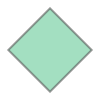

In [7]:
def border(s):
    r = s.radius+1
    poly = Polygon(*map(Point, [
        (s.x, s.y+r),
        (s.x-r, s.y),
        (s.x, s.y-r),
        (s.x+r, s.y)
    ]))
    return poly

border(test_sensors[0])

In [8]:
def common_intersections(i1, i2):
    for obj1 in i1:
        for obj2 in i2:
            yield from obj1.intersection(obj2)

[*reduce(common_intersections, [
    border(test_sensors[0]).intersection(border(test_sensors[1])),
    border(test_sensors[0]).intersection(border(test_sensors[2])),
])]

[]

In [9]:
def find_sensor_pairs(sensors):
    for (s1, s2) in combinations(sensors, 2):
        if s1.taxicab_distance(s2) - s1.radius - s2.radius == 2:
            yield (s1, s2)

[*find_sensor_pairs(test_sensors)]

[(Point2D(12, 14), Point2D(16, 7)),
 (Point2D(10, 20), Point2D(8, 7)),
 (Point2D(14, 17), Point2D(8, 7)),
 (Point2D(14, 17), Point2D(16, 7)),
 (Point2D(8, 7), Point2D(20, 14)),
 (Point2D(8, 7), Point2D(20, 1)),
 (Point2D(2, 0), Point2D(20, 1))]

In [10]:
def find_intersections(sensors):
    pairs = [*find_sensor_pairs(sensors)]
    for ((s1, s2), (s3, s4)) in combinations(pairs, 2):
        p1, p2, p3, p4 = map(border, (s1, s2, s3, s4))
        common_points = [*reduce(common_intersections, [
            p1.intersection(p2),
            p1.intersection(p3),
            p1.intersection(p4)
        ])]
        
        yield from common_points
    
%time [*find_intersections(test_sensors)]

CPU times: user 2.68 s, sys: 13.3 ms, total: 2.69 s
Wall time: 2.7 s


[Point2D(14, 11),
 Segment2D(Point2D(14, 11), Point2D(16, 13)),
 Point2D(14, 11),
 Segment2D(Point2D(8, 17), Point2D(10, 15)),
 Point2D(14, 11),
 Point2D(14, 11),
 Segment2D(Point2D(11, 14), Point2D(14, 11)),
 Point2D(14, 11),
 Point2D(18, 7),
 Point2D(18, 7),
 Point2D(12, 1)]

In [11]:
next(find_intersections(input_sensors))

Point2D(2673432, 3308112)

In [12]:
def tuning_frequency(p):
    return p.x * 4000000 + p.y

%time tuning_frequency(next(find_intersections(input_sensors)))

CPU times: user 203 ms, sys: 3.34 ms, total: 206 ms
Wall time: 205 ms


10693731308112